# Optimizing Model - Parameter Optimization for LightGBM

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/data_for_model_iterations_03.csv', sep = ',')

In [3]:
data_weather = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/weather.csv', sep = ',')

In [4]:
df_flight_info = data_flight_info.copy()
df_weather = data_weather.copy()

In [5]:
df_weather['value'] = df_weather['value'].str.lower()
# create a list of our conditions
conditions = [
    (df_weather['value'].str.contains('sunny')),
    (df_weather['value'].str.contains('cloud')),
    (df_weather['value'].str.contains('mist')),
    (df_weather['value'].str.contains('fog')),
    (df_weather['value'].str.contains('overcast')),
    (df_weather['value'].str.contains('rain')),
    (df_weather['value'].str.contains('drizzle')),
    (df_weather['value'].str.contains('thunder')),
    (df_weather['value'].str.contains('snow')),
    (df_weather['value'].str.contains('sleet')),
    (df_weather['value'].str.contains('blizzard')),
    ]

# create a list of the values we want to assign for each condition
values = ['sunny', 'cloudy', 'cloudy','cloudy','cloudy','rain','rain','rain','snow','snow','snow']

# create a new column and use np.select to assign values to it using our lists as arguments
df_weather['weather_type'] = np.select(conditions, values)
df_weather['weather_type'].value_counts()

sunny     5503
cloudy    4324
rain      2860
snow      1412
Name: weather_type, dtype: int64

In [6]:
df_weather['value'].value_counts().sum()

14099

In [7]:
# Creating year, month, date columns
df_weather['year'] = pd.DatetimeIndex(df_weather['date']).year
df_weather['month'] = pd.DatetimeIndex(df_weather['date']).month
df_weather['day'] = pd.DatetimeIndex(df_weather['date']).day
df_weather['weekday'] = ((pd.DatetimeIndex(df_weather['date']).dayofweek))

#### Merging weather data with flight data

In [8]:
df_weather.rename(columns={'date': 'fl_date', 'airport_code': 'origin'}, inplace=True)

In [9]:
df_flight_info = pd.merge(df_flight_info, df_weather[['fl_date','origin','weather_type']],  how='left', left_on=['fl_date','origin'], right_on = ['fl_date','origin'])


In [10]:
df_flight_info.head()

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,dep_time,crs_dep_time,dep_delay,dest,arr_time,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,month,day,weekday,total_carrier_delay,weather_type
0,2018-10-19,NK,NK,169,IAH,1433.0,1435,-2.0,LAS,1552.0,...,0.0,0.0,0.0,0.0,2018,10,19,0.0,5.841662,sunny
1,2018-09-24,NK,NK,169,IAH,1431.0,1435,-4.0,LAS,1531.0,...,0.0,0.0,0.0,0.0,2018,9,24,0.0,5.841662,rain
2,2018-03-21,NK,NK,128,LAX,2051.0,2100,-9.0,BWI,444.0,...,0.0,0.0,0.0,0.0,2018,3,21,0.0,5.841662,sunny
3,2018-04-24,NK,NK,616,BOS,1824.0,1822,2.0,MSP,2037.0,...,0.0,0.0,0.0,0.0,2018,4,24,0.0,5.841662,sunny
4,2018-04-22,NK,NK,310,LAX,2107.0,2105,2.0,FLL,443.0,...,0.0,0.0,0.0,0.0,2018,4,22,1.0,5.841662,cloudy


In [11]:
# Finding average route times
df_flight_info['flight_number'] = df_flight_info['op_unique_carrier'] + df_flight_info['op_carrier_fl_num'].astype(str)
route_time_grouped = df_flight_info.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

In [12]:
# Getting Average Weather Delay
weather_grouped1 = df_flight_info.groupby(by=['origin','month']).mean()
weather_grouped1.reset_index(inplace=True)
weather_grouped1['total_weather_delay'] = weather_grouped1['weather_delay']
weather_grouped1 = weather_grouped1[['origin','total_weather_delay']]

In [13]:
# Getting Average NAS Delay - Grouped by Flight Number
nas_grouped = df_flight_info.groupby(by='flight_number').mean()
nas_grouped.reset_index(inplace=True)
nas_grouped['total_nas_delay'] = nas_grouped['nas_delay']
nas_grouped = nas_grouped[['flight_number', 'total_nas_delay']]

# Getting Average Security Delay
security_grouped = df_flight_info.groupby(by='origin').mean()
security_grouped.reset_index(inplace=True)
security_grouped['total_security_delay'] = security_grouped['security_delay']
security_grouped = security_grouped[['origin','total_security_delay']]

# Getting Average Departure Delays by Route
dep_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
dep_delay_grouped.reset_index(inplace=True)
dep_delay_grouped['total_dep_delay'] = dep_delay_grouped['dep_delay']
dep_delay_grouped = dep_delay_grouped[['flight_number','total_dep_delay']]

# Getting Average Arrival Delays by Route
arr_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
arr_delay_grouped.reset_index(inplace=True)
arr_delay_grouped['total_arr_delay'] = arr_delay_grouped['arr_delay']
arr_delay_grouped = arr_delay_grouped[['flight_number','total_arr_delay']]

#Merge averages dataframes with original 
df_flight_info = df_flight_info.merge(security_grouped, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(nas_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(dep_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(arr_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(weather_grouped1, on = 'origin', how = 'outer')

## Model Training

In [14]:
#df_flight_info.isnull().sum()

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [16]:
# encoding df_flight_info 
df_flight_info["weather_type"] = df_flight_info["weather_type"].astype('category').cat.codes
df_flight_info["flight_number"] = df_flight_info["flight_number"].astype('category').cat.codes

In [17]:
df_flight_info.dtypes

fl_date                  object
mkt_unique_carrier       object
op_unique_carrier        object
op_carrier_fl_num         int64
origin                   object
dep_time                float64
crs_dep_time              int64
dep_delay               float64
dest                     object
arr_time                float64
arr_delay               float64
crs_arr_time              int64
actual_elapsed_time     float64
crs_elapsed_time        float64
distance                float64
carrier_delay           float64
weather_delay           float64
nas_delay               float64
security_delay          float64
late_aircraft_delay     float64
year                      int64
month                     int64
day                       int64
weekday                 float64
total_carrier_delay     float64
weather_type               int8
flight_number             int16
total_security_delay    float64
total_nas_delay         float64
average_route_time      float64
total_dep_delay         float64
total_ar

### Adding Total Weather Delay

In [18]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','flight_number','crs_elapsed_time','average_route_time','crs_arr_time','distance','year','month','day','weekday','total_carrier_delay', 'total_security_delay','total_nas_delay','total_dep_delay','total_arr_delay','weather_type','total_weather_delay']]
y = df_flight_info['arr_delay']

In [19]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [29]:
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV
def bayes_parameter_opt_lgb(X_train, y_train, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'regression', 'metric':'rmse'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 5781567, number of used features: 17
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.819205942030

[LightGBM] [Info] Start training from score 5.144891
[LightGBM] [Info] Start training from score 5.144833
[LightGBM] [Info] Start training from score 5.144930
|  5        |  0.6431   |  0.9946   |  0.3264   |  0.6526   |  38.59    |  9.692    |  45.14    |  66.6     |  52.98    |  0.8559   |
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.851823068170809, subsample=0.9023447381044342 will be ignored. Current value: bagging_fraction=0.851823068170809
[LightGBM] [Warning] bagging_fraction is set=0.851823068170809, subsample=0.9023447381044342 will be ignored. Current value: bagging_fraction=0.851823068170809
[LightGBM] [Warning] bagging_fraction is set=0.851823068170809, subsample=0.9023447381044342 will be ignored. Current value: bagging_fraction=0.851823068170809
[LightGBM] [Warning] bagging_fraction is set=0.851823068170809, sub

[LightGBM] [Warning] bagging_fraction is set=0.9740935568038949, subsample=0.940008263572769 will be ignored. Current value: bagging_fraction=0.9740935568038949
[LightGBM] [Warning] bagging_fraction is set=0.9740935568038949, subsample=0.940008263572769 will be ignored. Current value: bagging_fraction=0.9740935568038949
[LightGBM] [Warning] bagging_fraction is set=0.9740935568038949, subsample=0.940008263572769 will be ignored. Current value: bagging_fraction=0.9740935568038949
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 5781567, number of used features: 17
[LightGBM] [Warning] bagging_fraction is set=0.9740935568038949, subsample=0.940008263572769 will be ignored. Current value: bagging_fraction=0.9740935568038949

[LightGBM] [Warning] bagging_fraction is set=0.9022534679331193, subsample=0.5168969653573697 will be ignored. Current value: bagging_fraction=0.9022534679331193
[LightGBM] [Info] Start training from score 5.144891
[LightGBM] [Info] Start training from score 5.144833
[LightGBM] [Info] Start training from score 5.144930
|  10       |  0.6573   |  0.9023   |  0.6931   |  0.4663   |  59.03    |  20.47    |  48.44    |  94.19    |  61.48    |  0.5169   |
[LightGBM] [Warning] bagging_fraction is set=0.9022534679331193, subsample=0.5168969653573697 will be ignored. Current value: bagging_fraction=0.9022534679331193
[LightGBM] [Warning] bagging_fraction is set=0.8722154028274957, subsample=0.07075367348204263 will be ignored. Current value: bagging_fraction=0.8722154028274957
[LightGBM] [Warning] bagging_fraction is set=0.8722154028274957, subsample=0.07075367348204263 will be ignored. Current value: bagging_fraction=0.8722154028274957
[LightGBM] [Warning] bagging_fraction is set=0.8722154028

[LightGBM] [Warning] bagging_fraction is set=0.9836063675867542, subsample=0.1011988223298474 will be ignored. Current value: bagging_fraction=0.9836063675867542
[LightGBM] [Warning] bagging_fraction is set=0.9836063675867542, subsample=0.1011988223298474 will be ignored. Current value: bagging_fraction=0.9836063675867542
[LightGBM] [Warning] bagging_fraction is set=0.9836063675867542, subsample=0.1011988223298474 will be ignored. Current value: bagging_fraction=0.9836063675867542
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 5781567, number of used features: 17
[LightGBM] [Warning] bagging_fraction is set=0.9836063675867542, subsample=0.1011988223298474 will be ignored. Current value: bagging_fraction=0.983606367586

[LightGBM] [Warning] bagging_fraction is set=0.9668586565574406, subsample=0.9452065967526455 will be ignored. Current value: bagging_fraction=0.9668586565574406
[LightGBM] [Warning] bagging_fraction is set=0.9668586565574406, subsample=0.9452065967526455 will be ignored. Current value: bagging_fraction=0.9668586565574406
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 5781567, number of used features: 17
[LightGBM] [Warning] bagging_fraction is set=0.9668586565574406, subsample=0.9452065967526455 will be ignored. Current value: bagging_fraction=0.9668586565574406
[LightGBM] [Warning] bagging_fraction is set=0.9668586565574406, subsample=0.9452065967526455 will be ignored. Current value: bagging_fraction=0.966858656557

In [34]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='rmse'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

KeyError: 1

In [35]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.8277896457253541
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.5
params['num_leaves'] = 62
params['min_data'] = 55
params['max_depth'] = 27
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2737
[LightGBM] [Info] Number of data points in the train set: 8672350, number of used features: 17
[LightGBM] [Info] Start training from score 5.144885
Model RMSE is:  39.742361203280275
Model R2 Score is:  0.16815526421564875


In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot  as plt



params = {
    'booster': 'gbdt',
    'objective': 'regression',
    'num_leaves': 62,
    'subsample': 0.5,
    'bagging_freq': 1,
    'feature_fraction ': 0.8,
    'slient': 1,
    'learning_rate ': 8277896457253541,
    'seed': 0
}


# Construct training set
dtrain = lgb.Dataset(X_train,y_train)
dtest = lgb.Dataset(X_test,y_test)
num_rounds = 500
# xgboost model training
model = lgb.train(params,dtrain, num_rounds, valid_sets=[dtrain, dtest], 
                  verbose_eval=100, early_stopping_rounds=100)

# Make predictions on the test set
y_pred = model.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))

# Show important features
plot_importance(model)
plt.show()

[LightGBM] [Warning] Unknown parameter: 8277896457253541
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: 8277896457253541
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.308030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2738
[LightGBM] [Info] Number of data points in the train set: 8672350, number of used features: 17
[LightGBM] [Warning] Unknown parameter: 8277896457253541
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Info] Start training from score 5.144885
T

##### XGBoost

In [22]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  42.74958892660707
Model R2 Score is:  0.039126530436728646


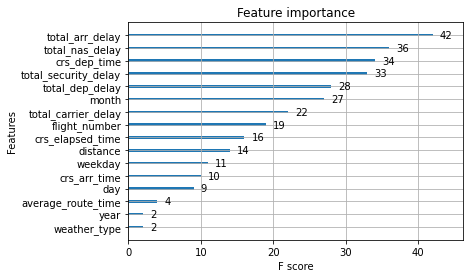

In [23]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

##### Random Forest

In [ ]:
#Create a Gaussian Regressor
clf=RandomForestRegressor(n_estimators=100)

In [ ]:
#Train the model using the training sets 
clf.fit(X_train,y_train)

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))